In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
from decouple import config
import json
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from authenticate_service_account import main
from utils import *

from sklearn.model_selection import train_test_split

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score


# Getting the data

## Query version

In [2]:
client = main()

query = """
SELECT *
FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
"""

query_job = client.query(query)

results = query_job.result()


In [3]:
gcp_data = results.to_dataframe()


In [6]:
gcp_data['dayofweek']


0          2
1          6
2          3
3          4
4          6
          ..
3699660    2
3699661    6
3699662    1
3699663    7
3699664    4
Name: dayofweek, Length: 3699665, dtype: Int64

## Offline version

In [8]:
new_data = gcp_data.to_csv('../raw_data/all_data_30_horizon_with_day_of_week', index=False)


In [3]:
new_data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

In [10]:
def create_train_test_no_split(df, random_states=42):
    """
    Returns train_data and test_data
    Input is the df
    If you wish, you can adjust the random state
    """

    train_data, test_data = train_test_split(df, test_size=0.2, random_state=random_states)

    return train_data, test_data


In [21]:
# train_data, test_data = create_train_test_no_split(data)


In [4]:
columns_for_model = ['OD', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'Seg_0_TravelDistanceKm', 'Seg_1_TravelDistanceKm', 'Seg_2_TravelDistanceKm', 'Seg_3_TravelDistanceKm',
                     'ItineraryRedirects', 'ODRedirects', 'PricePerPax',
                     'Seg_0_DurationMin' ,'Seg_1_DurationMin', 'Seg_2_DurationMin', 'Seg_3_DurationMin', 'DurationMin']


In [5]:
def ants_preprocess(data):
    data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])

    data_with_layover = calculate_total_layover_time(data_with_od, as_ratio=True)

    data_with_layover2 = calculate_distance_difference(data_with_layover, as_ratio=True)

    data_with_redirect_ratio = redirect_ratio(data_with_layover2)

    droped_values = drop_neg_layover_time(data_with_redirect_ratio)

    return droped_values


In [6]:
clean_data = new_data.dropna(subset='TravelDistanceKm').copy()


In [7]:
basic_processing_data = ants_preprocess(clean_data)

# basic_processing_test_data = ants_preprocess(test_data)


In [8]:
# sorted_data = data_with_layover[data_with_layover['total_layover_time'] > 0]['total_layover_time'].sort_values()
# cumulative = np.arange(1, len(sorted_data) +1) / len(sorted_data)

# plt.figure(figsize=(10,6))
# plt.plot(sorted_data, cumulative)
# plt.yticks(np.linspace(0, 1, 11))
# x_values = [125, 250, 375, 500, 750, 1000, 1250, 1500]  # Replace x1, x2, x3 with your specific values
# for x in x_values:
#     plt.axvline(x=x, linestyle='--', alpha=0.3)

# y_values = [0.4, 0.5, 0.7, 0.8]
# for y in y_values:
#     plt.axhline(y=y, color='green', linestyle='--', alpha=0.3)

# plt.title("Cumulative distribution of layover times")
# plt.xlabel('Time')
# plt.ylabel('% share of the data')


# Creating a baseline model

In this model we are using unscaled, and simple columns as shown in the columns_for_model_baseline variable below

In [9]:
columns_for_model_baseline = ['Stops','DurationMin', 'total_layover_time_ratio',
                             'total_distance_traveled','extra_travel_distance_ratio',
                             'TravelHorizonDays', 'redirect_ratio']

baseline_data = basic_processing_data[columns_for_model_baseline].copy()

# baseline_test_data = basic_processing_test_data[columns_for_model_baseline].copy()

# plt.figure(figsize=(10, 8))

# sns.heatmap(baseline_data.corr(), annot=True,  fmt=".2f", cmap='coolwarm',
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

X_train, X_test, y_train, y_test = create_train_test_split(baseline_data, 'redirect_ratio')

# X_train = baseline_data.drop('redirect_ratio', axis=1)
# y_train = baseline_data['redirect_ratio']
# X_test = baseline_test_data.drop('redirect_ratio', axis=1)
# y_test = baseline_test_data['redirect_ratio']


In [10]:
baseline_model = LinearRegression()

baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Baseline mse:", mse)
print("Coefficients:", baseline_model.coef_)


Baseline mse: 0.12659307915408818
Coefficients: [ 7.22404022e-02 -1.61689753e-04  2.31980699e-01  1.18691786e-05
  1.79560901e-02  3.03571600e-03]


In [11]:
r2_score(y_test, y_pred)


0.03422551403097063

## Baseline conclusions

Model is performing terribly with an mse of 0.020614984406709863, which is high relative to our target which is between 0-1

Coefficients suggest that order of feature importance goes
1. Stops
2. extra_travel_distance_ratio
3. Total_layover_time_ratio
4. TravelHorizonDays
5. DurationMin
6. total_distance_traveled

# Model v1

Dropping total_distance_traveled as it was the least useful - it was an oversight to include it. 
Now going to scale the data and see the difference

In [21]:
# columns_for_model_v1 = ['Stops','DurationMin', 'total_layover_time_ratio',
#                              'extra_travel_distance_ratio',
#                              'TravelHorizonDays', 'redirect_ratio']

# v1_train_data = basic_processing_train_data[columns_for_model_v1].copy()
# x_train_values = v1_train_data.drop('redirect_ratio', axis=1)

# v1_test_data = basic_processing_test_data[columns_for_model_v1].copy()
# x_test_values = v1_test_data.drop('redirect_ratio', axis=1)

# minmax_train_scaler = MinMaxScaler()
# minmax_scaled_train_data = minmax_train_scaler.fit_transform(x_train_values)

# minmax_test_scaler = MinMaxScaler()
# minmax_scaled_test_data = minmax_test_scaler.fit_transform(x_test_values)

# X_train_v1 = minmax_scaled_train_data
# y_train_v1 = v1_train_data['redirect_ratio']
# X_test_v1 = minmax_scaled_test_data
# y_test_v1 = v1_test_data['redirect_ratio']


In [22]:

# X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(minmax_scaled_train_data, v1_train_data['redirect_ratio'])


In [23]:
# v1_model = LinearRegression()

# v1_model.fit(X_train_v1, y_train_v1)

# y_pred_v1 = v1_model.predict(X_test_v1)

# mse_v1 = mean_squared_error(y_test_v1, y_pred_v1)
# print("Baseline mse:", mse_v1)
# print("Coefficients:", v1_model.coef_)


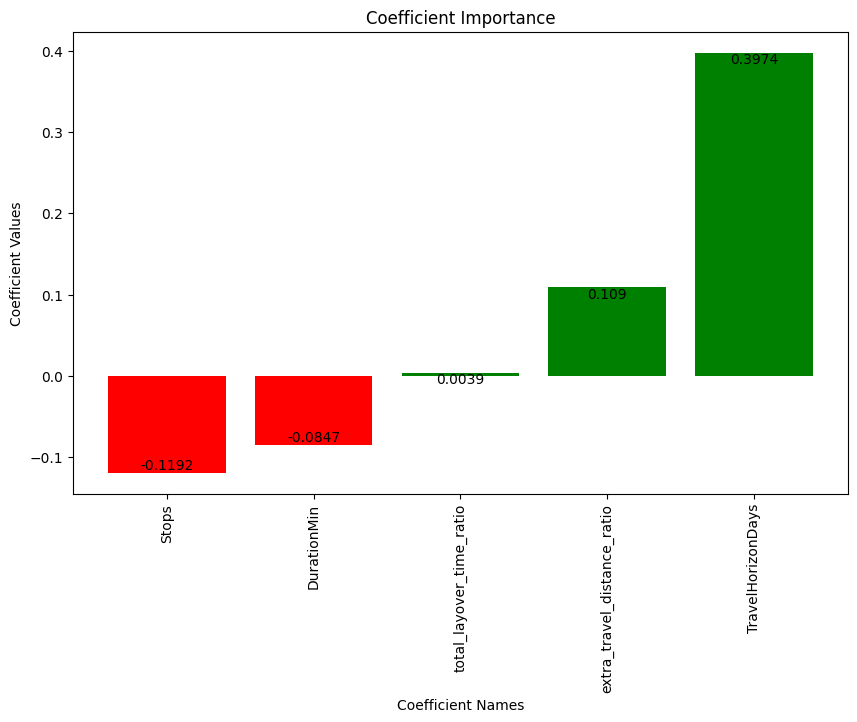

In [ ]:
# # Coefficients and their corresponding names (example names)
# coefficients = v1_model.coef_
# names = v1_train_data.drop('redirect_ratio', axis=1).columns

# # Creating the bar chart
# plt.figure(figsize=(10, 6))
# bars = plt.bar(names, coefficients, color=['red' if x < 0 else 'green' for x in coefficients])

# # Adding labels and title
# plt.xlabel('Coefficient Names')
# plt.ylabel('Coefficient Values')
# plt.title('Coefficient Importance')


# # Annotating each bar with its value
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom' if yval < 0 else 'top', ha='center')

# plt.xticks(rotation=90)
# # Showing the plot
# plt.show()


In [ ]:
# r2_score(y_test_v1, y_pred_v1)


0.3057872096526705

## model v2

### MORE DATA!

Plan here:
1. Encode the airports for the OD's
2. Filter out ODRedirects that are less than 5

In [24]:
#
OD_redirecst_5_mask = basic_processing_data['ODRedirects'] > 5
more_than_5_OD_redirects = basic_processing_data[OD_redirecst_5_mask]

# Removing perfect redirect ratios as they may confuse the model
# perfect_redirect_ratio_mask = more_than_5_OD_redirects['redirect_ratio']==1
# filtered_data = more_than_5_OD_redirects[perfect_redirect_ratio_mask]


In [25]:
more_than_5_OD_redirects.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

In [26]:
columns_for_model_v1 = ['Stops','DurationMin', 'total_layover_time_ratio', 'extra_travel_distance_ratio',
                        'TravelHorizonDays','OriginApt', 'DestinationApt', 'TravelDistanceKm',
                        'redirect_ratio']


In [27]:
good_columns = basic_processing_data[columns_for_model_v1]


In [28]:
good_columns


,Stops,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,TravelHorizonDays,OriginApt,DestinationApt,TravelDistanceKm,redirect_ratio
386,1,335,0.552239,1.006519,9,AAE,ORN,767.0,1.000000
387,0,145,0.000000,1.000000,2,AAE,CDG,1420.0,0.058824
388,1,450,0.600000,1.000000,2,AAE,CDG,1420.0,0.058824
389,1,400,0.562500,1.005634,2,AAE,CDG,1420.0,0.058824
390,1,245,0.326531,1.000000,2,AAE,ORY,1396.0,0.117647
...,...,...,...,...,...,...,...,...,...
2580499,0,120,0.000000,1.000000,5,ZUH,KMG,1133.0,0.800000
2580500,0,80,0.000000,1.000000,21,ZUH,KOW,461.0,1.000000
2580501,0,690,0.000000,1.000000,7,ZYL,MAN,8070.0,1.000000
2580502,3,1355,0.365314,1.168278,17,ZYL,MAN,8070.0,0.333333


In [29]:
import category_encoders as ce


In [30]:
o_encoder = ce.BinaryEncoder(cols=['OriginApt'])
df_binary = o_encoder.fit_transform(good_columns)

d_encoder = ce.BinaryEncoder(cols=['DestinationApt'])
all_binary = d_encoder.fit_transform(df_binary)


In [31]:
all_binary


,Stops,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,TravelHorizonDays,OriginApt_0,OriginApt_1,OriginApt_2,OriginApt_3,OriginApt_4,...,DestinationApt_4,DestinationApt_5,DestinationApt_6,DestinationApt_7,DestinationApt_8,DestinationApt_9,DestinationApt_10,DestinationApt_11,TravelDistanceKm,redirect_ratio
386,1,335,0.552239,1.006519,9,0,0,0,0,0,...,0,0,0,0,0,0,0,1,767.0,1.000000
387,0,145,0.000000,1.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1420.0,0.058824
388,1,450,0.600000,1.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1420.0,0.058824
389,1,400,0.562500,1.005634,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1420.0,0.058824
390,1,245,0.326531,1.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1396.0,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580499,0,120,0.000000,1.000000,5,0,1,1,1,0,...,1,1,0,0,0,1,1,0,1133.0,0.800000
2580500,0,80,0.000000,1.000000,21,0,1,1,1,0,...,0,1,0,0,1,0,1,0,461.0,1.000000
2580501,0,690,0.000000,1.000000,7,0,1,0,1,1,...,0,0,0,1,1,1,0,1,8070.0,1.000000
2580502,3,1355,0.365314,1.168278,17,0,1,0,1,1,...,0,0,0,1,1,1,0,1,8070.0,0.333333


In [32]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(all_binary.drop('redirect_ratio',
                                                                                axis=1), all_binary['redirect_ratio'])

v2_model = LinearRegression()

v2_model.fit(X_train_v2, y_train_v2)

y_pred_v2 = v2_model.predict(X_test_v2)

mse_v2 = mean_squared_error(y_test_v2, y_pred_v2)
print("Baseline mse:", mse_v2)
print("Coefficients:", v2_model.coef_)


Baseline mse: 0.11583300456126151
Coefficients: [ 6.52082183e-02 -1.30456270e-04  1.88210138e-01  1.88356166e-02
  3.24777213e-03  4.66698174e-01  8.86660201e-02 -1.32324981e-02
  4.37541350e-02  1.71160465e-02  5.40169565e-03 -1.75630291e-02
 -1.33387751e-02 -1.74639680e-03  2.16666013e-03  7.95335541e-04
 -4.79305444e-03  5.09422550e-01  2.58174038e-01  1.45318030e-01
  9.88197612e-02  3.67305071e-02  6.68205140e-02  1.44772344e-02
 -2.27381304e-02 -2.10448018e-02  1.11162428e-02  1.35263678e-02
 -6.27292604e-03  1.51025325e-05]


In [33]:
r2_score(y_test_v2, y_pred_v2)


0.11520339801650736

In [34]:
import xgboost as xgb


In [35]:
model_xg = xgb.XGBRegressor(objective ='reg:squarederror')

# Train the model
model_xg.fit(X_train_v2, y_train_v2)

# Make predictions
y_pred_v2 = model_xg.predict(X_test_v2)

# Evaluate the model
rmse = mean_squared_error(y_test_v2, y_pred_v2, squared=False)


In [36]:
rmse, r2_score(y_test_v2, y_pred_v2)


(0.29547870362050455, 0.3330957356551082)

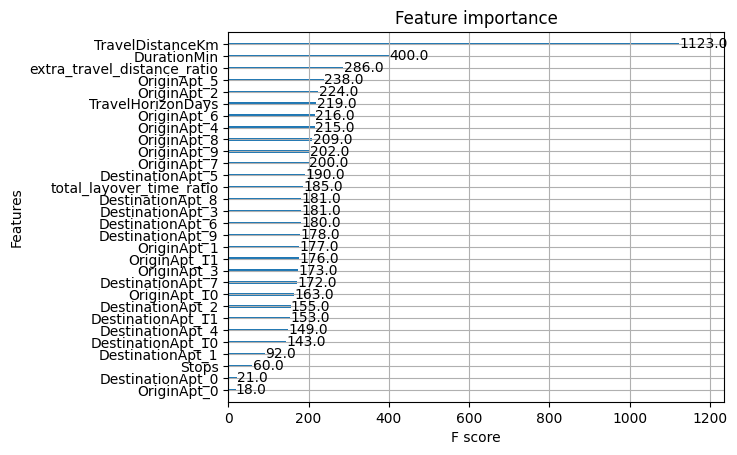

In [37]:
feature_importance = model_xg.feature_importances_

# Visualize feature importance
xgb.plot_importance(model_xg)
plt.show()


# model v3

Try clustering models, but include ODRedirects

In [38]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score


In [39]:
columns_for_model_knn = ['DurationMin', 'total_layover_time_ratio', 'extra_travel_distance_ratio',
                        'TravelHorizonDays','OriginApt', 'DestinationApt', 'TravelDistanceKm', 'od_pop',
                        'redirect_ratio']


In [40]:
od_competitivness = pd.DataFrame(basic_processing_data['OD'].value_counts()).reset_index()


In [41]:
od_popularity = pd.DataFrame(basic_processing_data.groupby('OD')['ODRedirects'].sum()).reset_index().set_index('OD')
# od_popularity.rename(columns={'ODRedirects':'Popularity'}, inplace=True)
# od_popularity['OD'] = od_popularity['OD'].astype('str')


In [42]:
new_column = []

for i in range(len(basic_processing_data)):
    od_name = basic_processing_data.iloc[i]['OD']
    value = od_popularity.loc[od_name][0]

    new_column.append(value)


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_68975/839301864.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = od_popularity.loc[od_name][0]


In [43]:
basic_processing_data['od_pop'] = new_column


In [44]:
good_columns_knn = basic_processing_data[columns_for_model_knn]


In [45]:
good_columns_knn.columns


Index(['DurationMin', 'total_layover_time_ratio',
       'extra_travel_distance_ratio', 'TravelHorizonDays', 'OriginApt',
       'DestinationApt', 'TravelDistanceKm', 'od_pop', 'redirect_ratio'],
      dtype='object')

In [186]:
o_encoder_knn = ce.BinaryEncoder(cols=['OriginApt'])
df_binary_knn = o_encoder_knn.fit_transform(good_columns_knn)

d_encoder_knn = ce.BinaryEncoder(cols=['DestinationApt'])
all_binary_knn = d_encoder_knn.fit_transform(df_binary_knn)


In [187]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(all_binary_knn.drop('redirect_ratio',
                                                                                axis=1), all_binary_knn['redirect_ratio'], random_state=42)


In [ ]:

# Creating the KNN classifier
k = 5  # Number of neighbors
knn = KNeighborsRegressor(n_neighbors=k)

# Fitting the model with training data
knn.fit(X_train_knn, y_train_knn)


In [ ]:
# Making predictions on the test set
y_pred_knn = knn.predict(X_test_knn)


In [49]:
r2_score(y_true=y_test_knn, y_pred=y_pred_knn)


0.5850871581480879

In [113]:
mean_absolute_error(y_test_knn, y_pred_knn)


0.16343058225914942

In [50]:
mask = basic_processing_data['OD'] == 'BCNBUD'

basic_processing_data[mask]


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,ItineraryRedirects,ODRedirects,OD,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio,redirect_ratio,od_pop
2350,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,9,20,BCNBUD,145.0,0.0,0.0,1522.0,1.0,0.450000,5882
2351,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,4,20,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.200000,5882
2352,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,1,20,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.050000,5882
2353,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,5,20,BCNBUD,160.0,0.0,0.0,1522.0,1.0,0.250000,5882
2354,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,1,20,BCNBUD,145.0,0.0,0.0,1522.0,1.0,0.050000,5882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454226,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,5,35,BCNBUD,160.0,0.0,0.0,1522.0,1.0,0.142857,5882
2454227,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,4,35,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.114286,5882
2454228,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,9,35,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.257143,5882
2454229,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,5,35,BCNBUD,160.0,0.0,0.0,1522.0,1.0,0.142857,5882


In [51]:
new_test = np.array(X_test_knn.iloc[2350]).reshape(1,-1)


array([[2.67000000e+03, 5.20599251e-01, 1.08710619e+00, 1.20000000e+01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.33630000e+04, 1.68000000e+02]])

In [54]:
pred, indic = knn.kneighbors(new_test, n_neighbors=10,return_distance=True)


/Users/antonis/.pyenv/versions/3.12.0/envs/OptiFlyAi/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [ ]:
columns_for_assesing_knn = ['DurationMin', 'total_layover_time_ratio', 'extra_travel_distance_ratio',
                        'TravelHorizonDays','OriginApt', 'DestinationApt', 'TravelDistanceKm', 'od_pop',
                        'redirect_ratio']


In [56]:
lower_columns = basic_processing_data[columns_for_model_knn]


In [58]:
lower_columns.iloc[indic[0]]


,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,TravelHorizonDays,OriginApt,DestinationApt,TravelDistanceKm,od_pop,redirect_ratio
661432,555,0.324324,1.290166,1,MCT,CCU,3081.0,92,0.076923
728008,80,0.000000,1.000000,7,BOM,BHO,659.0,1108,0.142857
1798733,130,0.000000,1.000000,28,BVA,OPO,1241.0,20578,0.203704
886308,115,0.000000,1.000000,0,FRA,CLJ,1171.0,153,0.545455
136315,80,0.000000,1.000000,3,CPH,PRG,622.0,2133,0.222222
1713140,110,0.000000,1.000000,28,HLZ,CHC,669.0,31,1.000000
466317,1065,0.201878,1.299439,18,ABJ,YUL,8025.0,1715,0.500000
270157,330,0.181818,1.007546,7,HAM,LCA,2783.0,190,0.222222
243447,105,0.000000,1.000000,20,FUK,SDJ,1070.0,152,0.333333
72615,725,0.000000,1.000000,30,RUN,ORY,9359.0,4694,0.142857


In [75]:
knn_performance_df= pd.DataFrame({'true_value':y_test_knn, 'pred_value':y_pred_knn, 'DurationMin':X_test_knn['DurationMin'],
                                  "popularity":X_test_knn['od_pop']})

knn_performance_df['difference'] = knn_performance_df['pred_value'] - knn_performance_df['true_value']


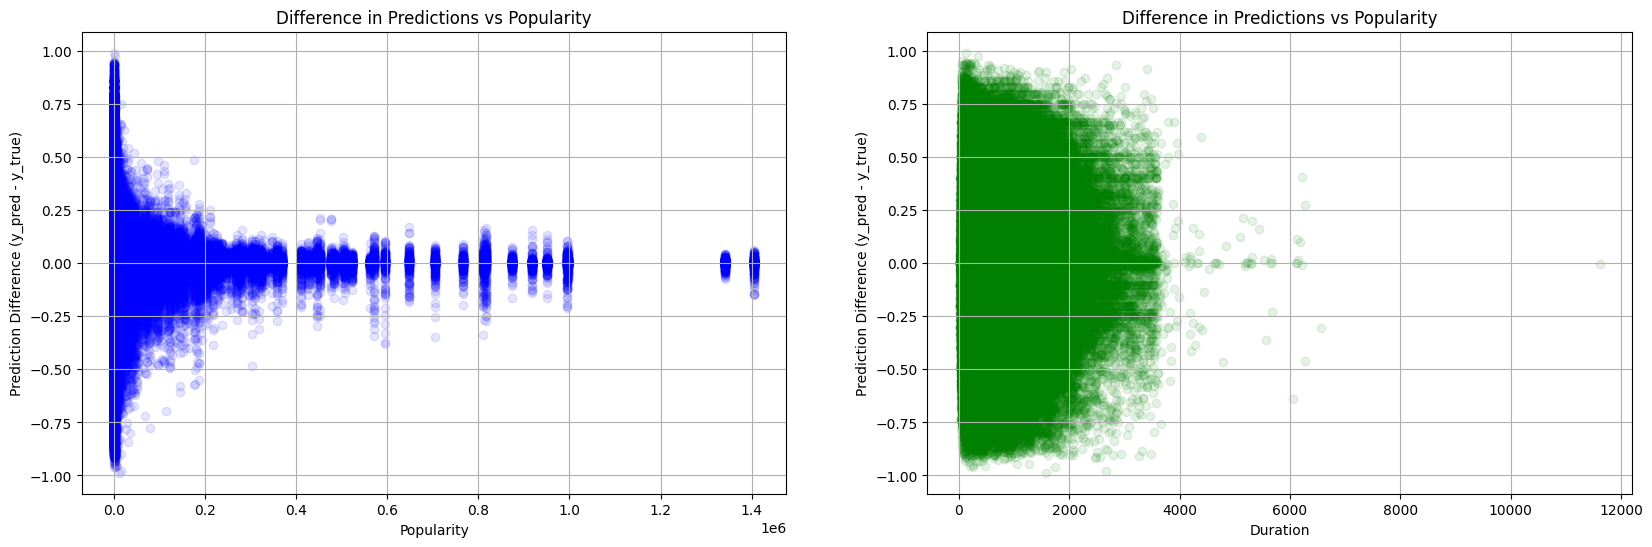

In [107]:
fig, axs = plt.subplot_mosaic([[1, 2]], figsize=(20, 6))

plt.scatter(knn_performance_df['popularity'], knn_performance_df['difference'], color='blue', alpha=0.1)
plt.set_title('Difference in Predictions vs Popularity')
plt.set_xlabel('Popularity')
plt.set_ylabel('Prediction Difference (y_pred - y_true)')
plt.grid(True)

axs[2].scatter(knn_performance_df['DurationMin'], knn_performance_df['difference'], color='green', alpha=0.1)
axs[2].set_title('Difference in Predictions vs Popularity')
axs[2].set_xlabel('Duration')
axs[2].set_ylabel('Prediction Difference (y_pred - y_true)')
axs[2].grid(True)

plt.show()


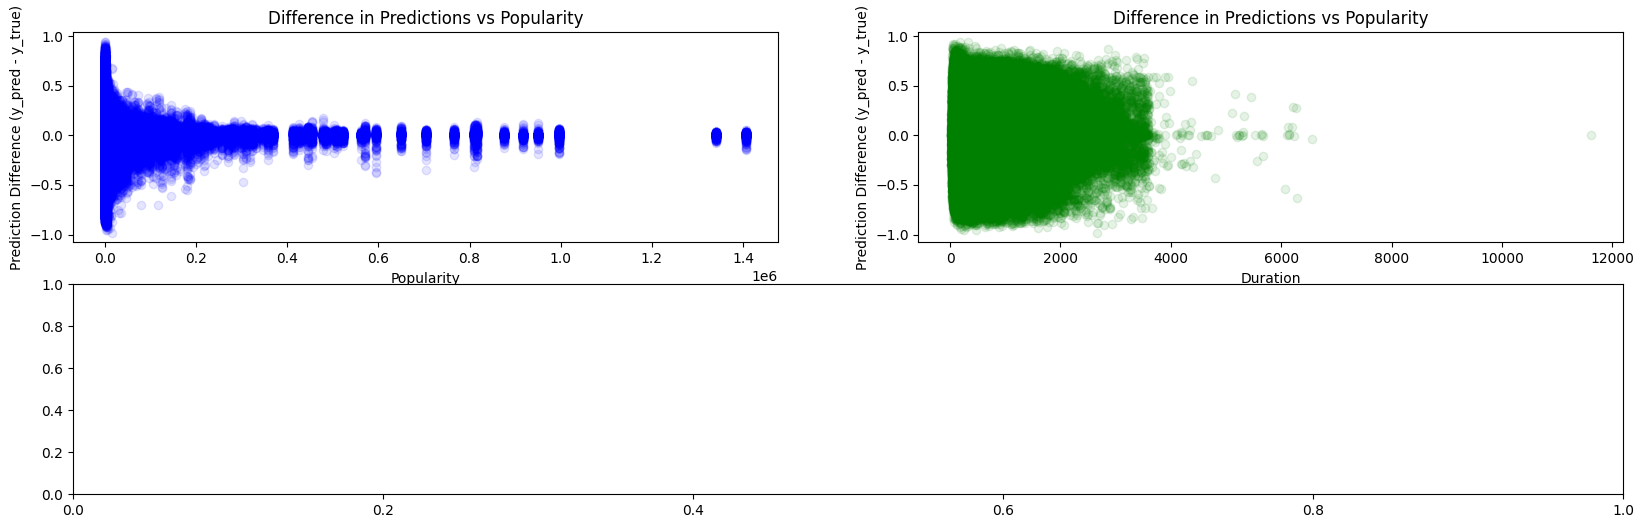

In [101]:
k = 10  # Number of neighbors
knn_10 = KNeighborsRegressor(n_neighbors=k, n_jobs=3)

# Fitting the model with training data
knn_10.fit(X_train_knn, y_train_knn)

y_pred_knn_10 = knn_10.predict(X_test_knn)

knn_performance_df_10= pd.DataFrame({'true_value':y_test_knn, 'pred_value':y_pred_knn_10, 'DurationMin':X_test_knn['DurationMin'],
                                  "popularity":X_test_knn['od_pop']})

knn_performance_df_10['difference'] = knn_performance_df_10['pred_value'] - knn_performance_df_10['true_value']


In [112]:
mean_absolute_error(y_test_knn, y_pred_knn_10)


0.1622179262394587

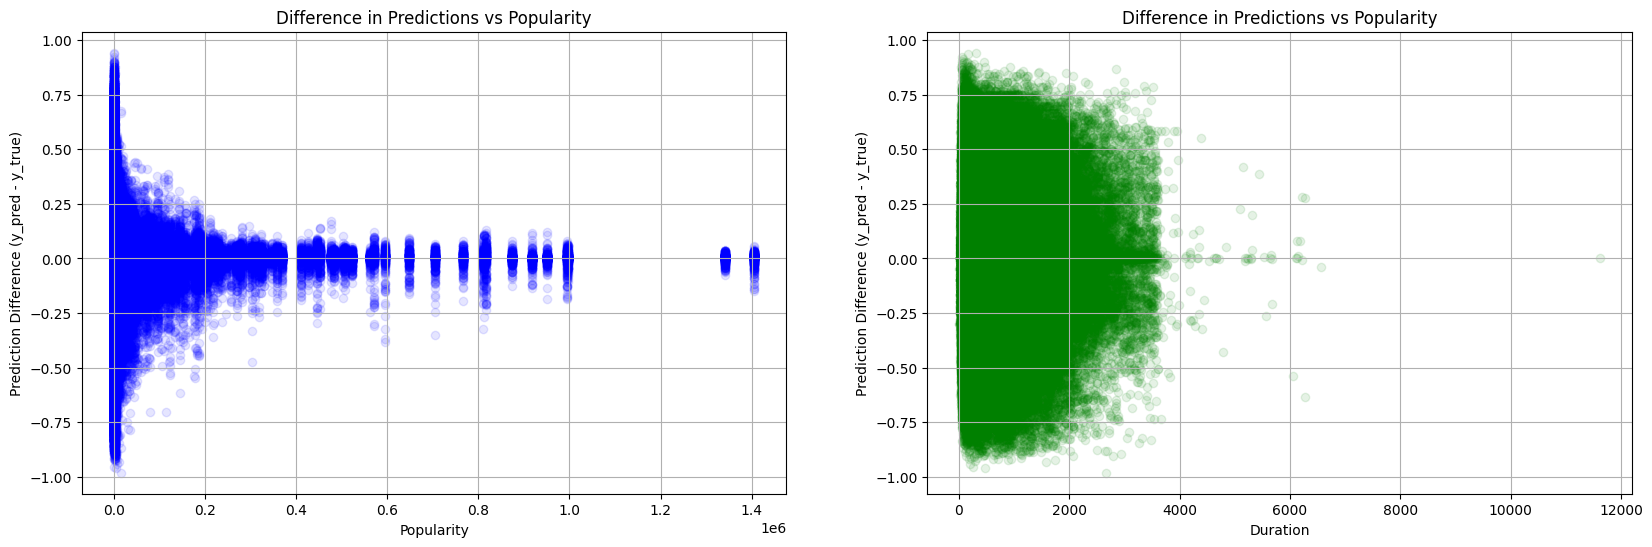

In [105]:
fig, axs = plt.subplot_mosaic([[1, 2]], figsize=(20, 6))

axs[1].scatter(knn_performance_df_10['popularity'], knn_performance_df_10['difference'], color='blue', alpha=0.1)
axs[1].set_title('Difference in Predictions vs Popularity')
axs[1].set_xlabel('Popularity')
axs[1].set_ylabel('Prediction Difference (y_pred - y_true)')
axs[1].grid(True)

axs[2].scatter(knn_performance_df_10['DurationMin'], knn_performance_df_10['difference'], color='green', alpha=0.1)
axs[2].set_title('Difference in Predictions vs Popularity')
axs[2].set_xlabel('Duration')
axs[2].set_ylabel('Prediction Difference (y_pred - y_true)')
axs[2].grid(True)

plt.show()


In [108]:
k = 100  # Number of neighbors
knn_100 = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)

# Fitting the model with training data
knn_100.fit(X_train_knn, y_train_knn)

y_pred_knn_100 = knn_100.predict(X_test_knn)

knn_performance_df_100= pd.DataFrame({'true_value':y_test_knn, 'pred_value':y_pred_knn_100, 'DurationMin':X_test_knn['DurationMin'],
                                  "popularity":X_test_knn['od_pop']})

knn_performance_df_100['difference'] = knn_performance_df_100['pred_value'] - knn_performance_df_100['true_value']


In [111]:
mean_absolute_error(y_test_knn, y_pred_knn_100)


0.1692879015094881

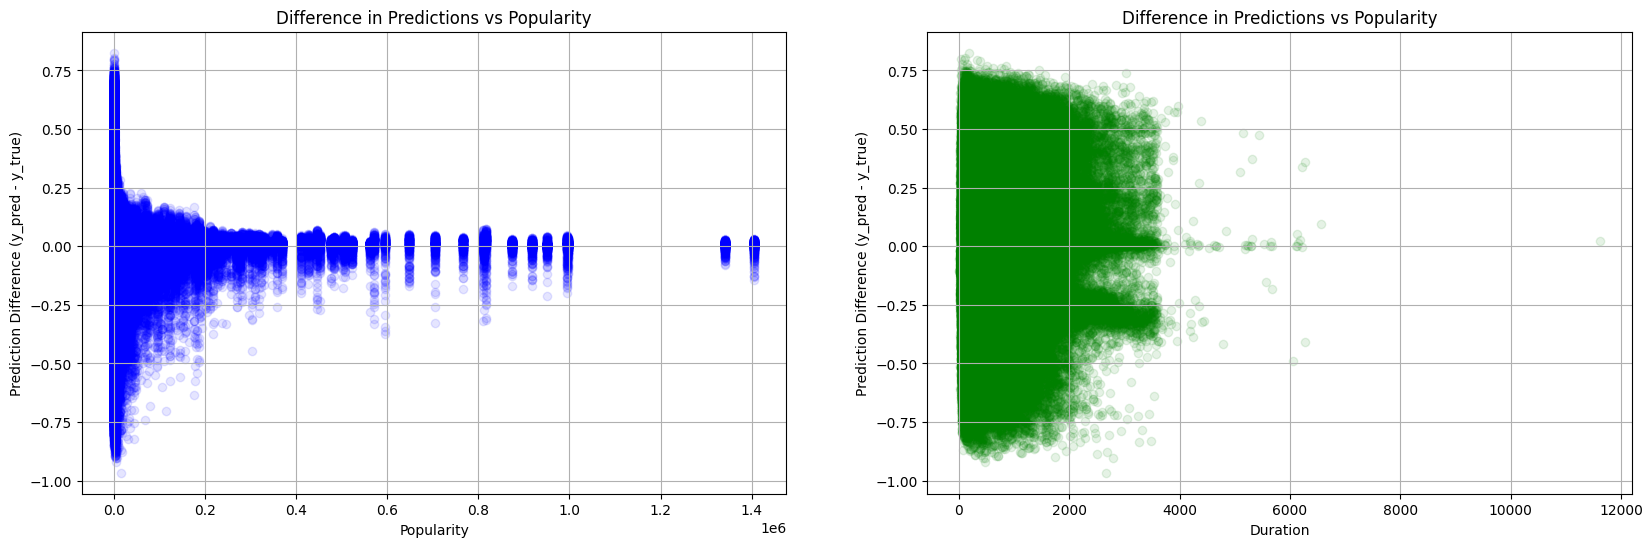

In [109]:
fig, axs = plt.subplot_mosaic([[1, 2]], figsize=(20, 6))

axs[1].scatter(knn_performance_df_100['popularity'], knn_performance_df_100['difference'], color='blue', alpha=0.1)
axs[1].set_title('Difference in Predictions vs Popularity')
axs[1].set_xlabel('Popularity')
axs[1].set_ylabel('Prediction Difference (y_pred - y_true)')
axs[1].grid(True)

axs[2].scatter(knn_performance_df_100['DurationMin'], knn_performance_df_100['difference'], color='green', alpha=0.1)
axs[2].set_title('Difference in Predictions vs Popularity')
axs[2].set_xlabel('Duration')
axs[2].set_ylabel('Prediction Difference (y_pred - y_true)')
axs[2].grid(True)

plt.show()


# Scaled KNN model

In [159]:
o_encoder_knn = ce.BinaryEncoder(cols=['OriginApt'])
df_binary_knn = o_encoder_knn.fit_transform(good_columns_knn)

d_encoder_knn = ce.BinaryEncoder(cols=['DestinationApt'])
all_binary_knn = d_encoder_knn.fit_transform(df_binary_knn)


array([[<Axes: title={'center': 'DurationMin'}>,
        <Axes: title={'center': 'TravelDistanceKm'}>],
       [<Axes: title={'center': 'od_pop'}>,
        <Axes: title={'center': 'extra_travel_distance_ratio'}>],
       [<Axes: title={'center': 'total_layover_time_ratio'}>,
        <Axes: title={'center': 'TravelHorizonDays'}>]], dtype=object)

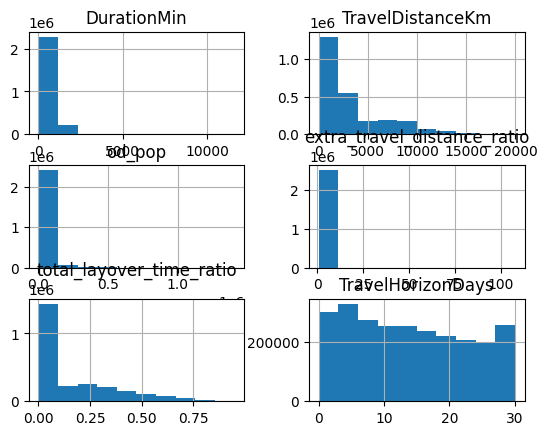

In [160]:
columns_to_scale = ['DurationMin', 'TravelDistanceKm', 'od_pop', 'extra_travel_distance_ratio',
                    'total_layover_time_ratio', 'TravelHorizonDays']

all_binary_knn[columns_to_scale].hist()


In [161]:
box_cox_columns = ['DurationMin', 'TravelDistanceKm', 'od_pop', 'extra_travel_distance_ratio']

yeo_johnson_columns = ['total_layover_time_ratio', 'TravelHorizonDays']


In [162]:
for col in box_cox_columns:
    data = all_binary_knn[col].values

    all_binary_knn[col], best_lambda = stats.boxcox(all_binary_knn[col])


In [163]:
for col in yeo_johnson_columns:
    data = all_binary_knn[col].values

    all_binary_knn[col], lambda_yj = stats.yeojohnson(all_binary_knn[col])


array([[<Axes: title={'center': 'DurationMin'}>,
        <Axes: title={'center': 'TravelDistanceKm'}>],
       [<Axes: title={'center': 'od_pop'}>,
        <Axes: title={'center': 'extra_travel_distance_ratio'}>],
       [<Axes: title={'center': 'total_layover_time_ratio'}>,
        <Axes: title={'center': 'TravelHorizonDays'}>]], dtype=object)

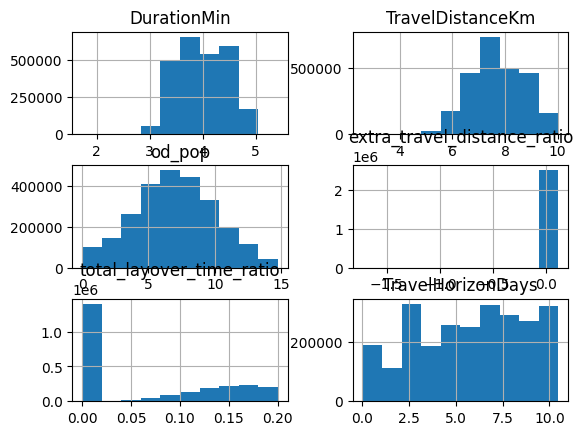

In [167]:
all_binary_knn[columns_to_scale].hist()


In [153]:
all_binary_knn


,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,TravelHorizonDays,OriginApt_0,OriginApt_1,OriginApt_2,OriginApt_3,OriginApt_4,OriginApt_5,...,DestinationApt_5,DestinationApt_6,DestinationApt_7,DestinationApt_8,DestinationApt_9,DestinationApt_10,DestinationApt_11,TravelDistanceKm,od_pop,redirect_ratio
386,4.084648,0.183325,0.006318,9,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6.701301,3.118649,1.000000
387,3.668157,-0.000000,0.000000,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,7.328678,5.674006,0.058824
388,4.220989,0.186756,0.000000,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,7.328678,5.674006,0.058824
389,4.167199,0.184114,0.005483,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,7.328678,5.674006,0.058824
390,3.934298,0.154814,0.000000,2,0,0,0,0,0,0,...,0,0,0,0,0,1,1,7.311301,5.674006,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580499,3.567610,-0.000000,0.000000,5,0,1,1,1,0,1,...,1,0,0,0,1,1,0,7.098573,2.969482,0.800000
2580500,3.343701,-0.000000,0.000000,21,0,1,1,1,0,1,...,1,0,0,1,0,1,0,6.183520,0.000000,1.000000
2580501,4.409447,-0.000000,0.000000,7,0,1,0,1,1,0,...,0,0,1,1,1,0,1,9.104007,4.755135,1.000000
2580502,4.686542,0.161765,0.085297,17,0,1,0,1,1,0,...,0,0,1,1,1,0,1,9.104007,4.755135,0.333333


In [174]:
X_train_knn_scaled, X_test_knn_scaled, y_train_knn_scaled, y_test_knn_scaled = train_test_split(all_binary_knn.drop('redirect_ratio',
                                                                                axis=1), all_binary_knn['redirect_ratio'], random_state=42)


In [175]:
k = 10  # Number of neighbors
knn_10_scaled = KNeighborsRegressor(n_neighbors=k, n_jobs=3)

# Fitting the model with training data
knn_10_scaled.fit(X_train_knn_scaled, y_train_knn_scaled)

y_pred_knn_10_scaled = knn_10_scaled.predict(X_test_knn_scaled)

knn_performance_df_10_scaled= pd.DataFrame({'true_value':y_test_knn_scaled, 'pred_value':y_pred_knn_10_scaled, 'DurationMin':X_test_knn_scaled['DurationMin'],
                                  "popularity":X_test_knn_scaled['od_pop']})

knn_performance_df_10_scaled['difference'] = knn_performance_df_10_scaled['pred_value'] - knn_performance_df_10_scaled['true_value']


In [188]:
knn_performance_df_10_scaled= pd.DataFrame({'true_value':y_test_knn_scaled, 'pred_value':y_pred_knn_10_scaled, 'DurationMin':X_test_knn['DurationMin'],
                                  "popularity":X_test_knn['od_pop']})

knn_performance_df_10_scaled['difference'] = knn_performance_df_10_scaled['pred_value'] - knn_performance_df_10_scaled['true_value']


In [189]:
knn_performance_df_10_scaled


,true_value,pred_value,DurationMin,popularity,difference
1010831,0.004854,0.001282,630,594616,-0.003572
2080131,0.250000,0.338571,767,1774,0.088571
1283870,0.500000,0.397500,172,343,-0.102500
828039,0.012195,0.027300,490,277618,0.015105
1776132,1.000000,0.700000,110,100,-0.300000
...,...,...,...,...,...
1349877,0.151515,0.217918,145,12233,0.066403
2331007,0.076923,0.276014,420,766,0.199091
1197901,1.000000,0.866667,285,39,-0.133333
1323963,0.052632,0.208772,605,171,0.156140


In [190]:
mean_absolute_error(y_test_knn_scaled, y_pred_knn_10_scaled)


0.1622302487645452

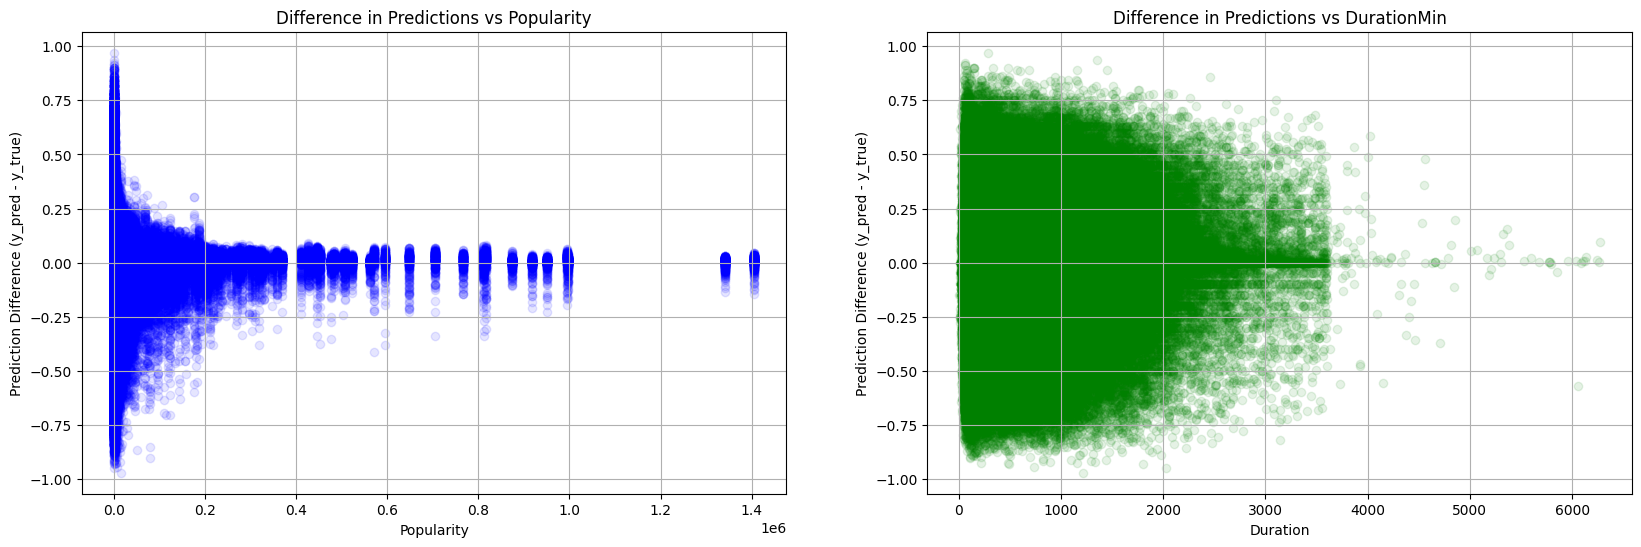

In [192]:
fig, axs = plt.subplot_mosaic([[1, 2]], figsize=(20, 6))

axs[1].scatter(knn_performance_df_10_scaled['popularity'], knn_performance_df_10_scaled['difference'], color='blue', alpha=0.1)
axs[1].set_title('Difference in Predictions vs Popularity')
axs[1].set_xlabel('Popularity')
axs[1].set_ylabel('Prediction Difference (y_pred - y_true)')
axs[1].grid(True)

axs[2].scatter(knn_performance_df_10_scaled['DurationMin'], knn_performance_df_10_scaled['difference'], color='green', alpha=0.1)
axs[2].set_title('Difference in Predictions vs DurationMin')
axs[2].set_xlabel('Duration')
axs[2].set_ylabel('Prediction Difference (y_pred - y_true)')
axs[2].grid(True)

plt.show()


In [193]:
r2_score(y_test_knn_scaled, y_pred_knn_10_scaled)


0.6126889902269408